# Credit_Card_Fraud_Detection_Using_Autoencoders_in_Keras

In [41]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid',palette='muted',font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ['Normal','Fraud']

In [9]:
df = pd.read_csv('creditcard.csv')

## Exploration

In [10]:
df.shape

(284807, 31)

In [11]:
## missing values
df.isnull().values.any()

False

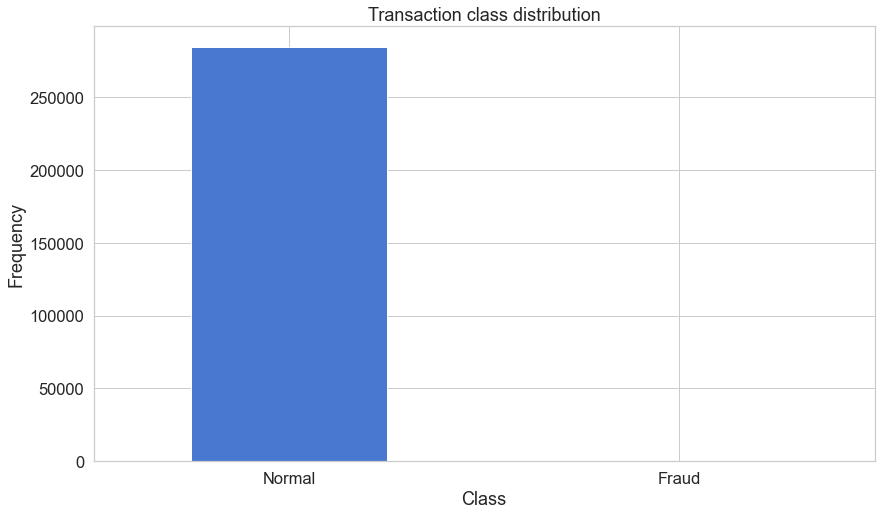

In [12]:
count_classes = pd.value_counts(df.Class, sort= True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title('Transaction class distribution')
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel('Frequency')
plt.show()

Data is highly imbalanced. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions

In [13]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [14]:
frauds.shape

(492, 31)

In [15]:
normal.shape

(284315, 31)

How different are the amount of money used in different transaction classes?

In [16]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [17]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

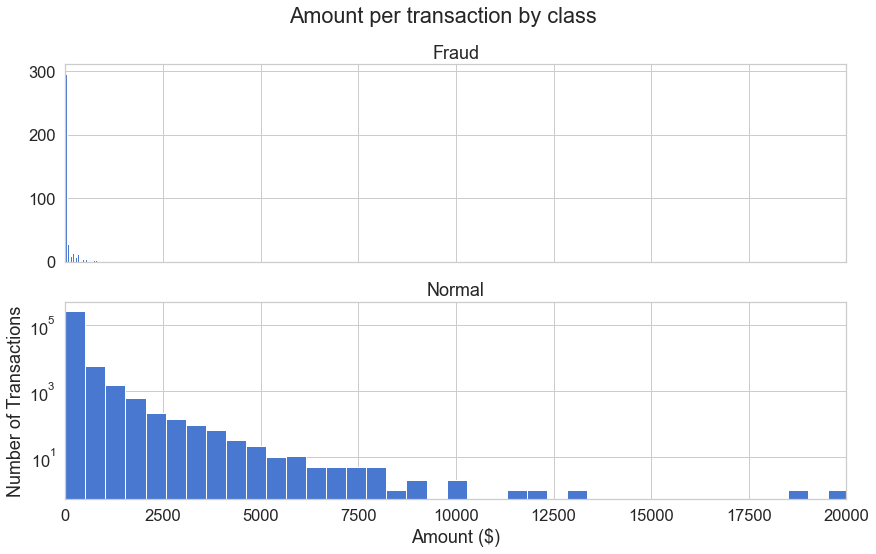

In [18]:
f, (ax1,ax2) = plt.subplots(2,1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0,20000))
plt.yscale('log')
plt.show()

Do fraudlent transactions occur more often during certain time?

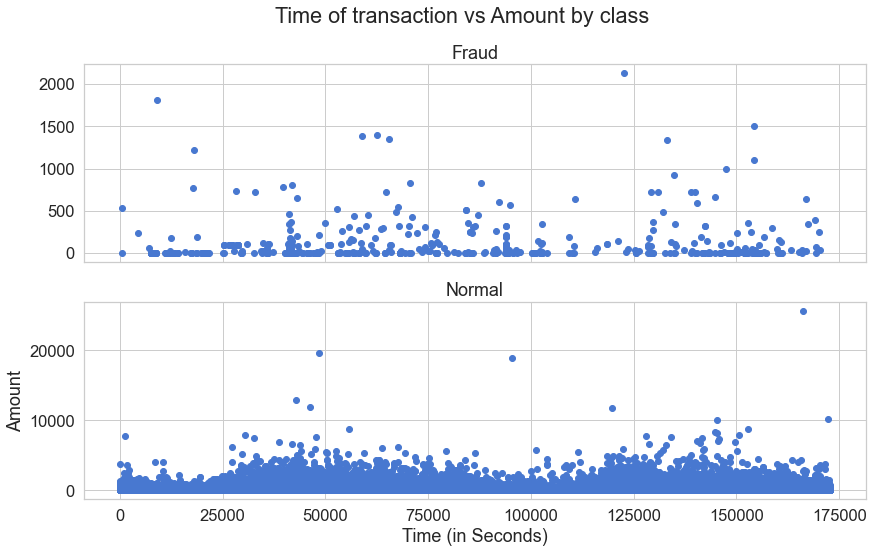

In [19]:
f, (ax1,ax2) = plt.subplots(2,1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')


ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Doesn't seem like the time of transaction really matter

# Autoencoders

Preparing the data

In [20]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'],axis=1)

data['Amount'] = StandardScaler().fit_transform(data.Amount.values.reshape(-1,1))

Training the Autoencoder is gonna be a bit different from what we are used to. Let's say we have a dataset containing a lot of 
non fraudulent transactions at hand. We want to detect any anomaly on new transactions. We will create this situation by training 
our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance 
of our model. We will reserve 20% of our data for testing

In [21]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'],axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'],axis=1)

X_train = X_train.values
X_test = X_test.values 

In [22]:
X_train.shape

(227451, 29)

# Building the model

Our Autoencoders uses 4 fully connected layers with 14,7,7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for decoder. Additionally, L1 regularization is used during training

In [23]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [24]:
input_layer = Input(shape=(input_dim,))

encoder = Dense(encoding_dim, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim/2),activation='relu')(encoder)

decoder = Dense(int(encoding_dim/2),activation='tanh')(encoder)
decoder = Dense(input_dim,activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)


Let's train the model for 100 epochs with a batch size of 32 samples and save the best performing model to file. The ModelCheckpoint
provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands

In [25]:
nb_epochs = 100
batch_size = 32

autoencoder.compile(optimizer='adam', loss ='mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.h5',verbose=0,save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,write_graph=True,write_images=True)

history = autoencoder.fit(X_train,X_train,epochs=nb_epochs,batch_size=batch_size,shuffle=True,
                          validation_data=(X_test,X_test),verbose=1,callbacks=[checkpointer,tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.8095 - accuracy: 0.5899 - val_loss: 0.7809 - val_accuracy: 0.6630
Epoch 2/100
7108/7108 [==============================] - 18s 2ms/step - loss: 0.7375 - accuracy: 0.6873 - val_loss: 0.7605 - val_accuracy: 0.7015
Epoch 3/100
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7251 - accuracy: 0.7011 - val_loss: 0.7544 - val_accuracy: 0.7080
Epoch 4/100
7108/7108 [==============================] - 18s 2ms/step - loss: 0.7189 - accuracy: 0.7043 - val_loss: 0.7495 - val_accuracy: 0.6984
Epoch 5/100
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7141 - accuracy: 0.7082 - val_loss: 0.7446 - val_accuracy: 0.7107
Epoch 6/100
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7105 - accuracy: 0.7102 - val_loss: 0.7423 - val_accuracy: 0.7085
Epoch 7/100
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7088 - accuracy: 0.7122 - val_loss: 0.7426 -

Epoch 57/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.6911 - accuracy: 0.7240 - val_loss: 0.7278 - val_accuracy: 0.7270
Epoch 58/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.6908 - accuracy: 0.7259 - val_loss: 0.7371 - val_accuracy: 0.7139
Epoch 59/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.6907 - accuracy: 0.7274 - val_loss: 0.7271 - val_accuracy: 0.7253
Epoch 60/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.6911 - accuracy: 0.7275 - val_loss: 0.7274 - val_accuracy: 0.7274
Epoch 61/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.6906 - accuracy: 0.7279 - val_loss: 0.7263 - val_accuracy: 0.7223
Epoch 62/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.6908 - accuracy: 0.7285 - val_loss: 0.7253 - val_accuracy: 0.7354
Epoch 63/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.6907 - accuracy: 0.7292 - val_loss: 0

In [26]:
autoencoder = load_model('model.h5')

# Evaluation

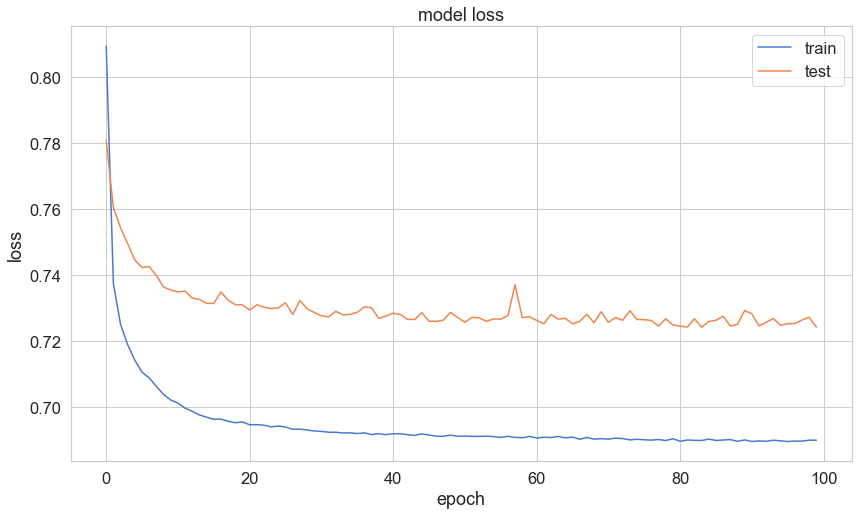

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper right')
plt.show()

The resonstrution error on our training and test data seems to be converge nicely. Is it low enough? Let's have a closer look at the error distribution

In [28]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 5s 2ms/step


In [29]:
mse = np.mean(np.power(X_test - predictions, 2),axis=1)
error_df = pd.DataFrame({'reconstruction_error':mse,'true_class':y_test})

In [30]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.723236,0.001720
std,3.403462,0.041443
min,0.039996,0.000000
25%,0.239907,0.000000
50%,0.386043,0.000000
75%,0.615329,0.000000
max,265.090059,1.000000


# Reconstruction error without fraud

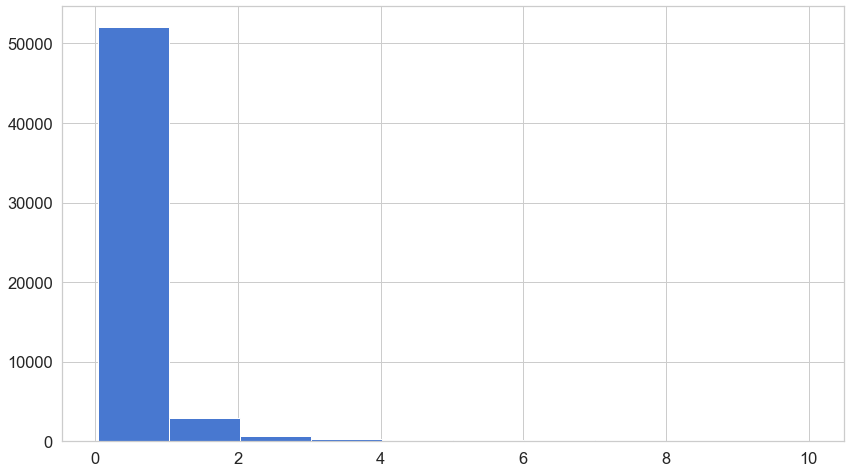

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']==0) & (error_df['reconstruction_error']<10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins =10)

# Reconstruction error without fraud

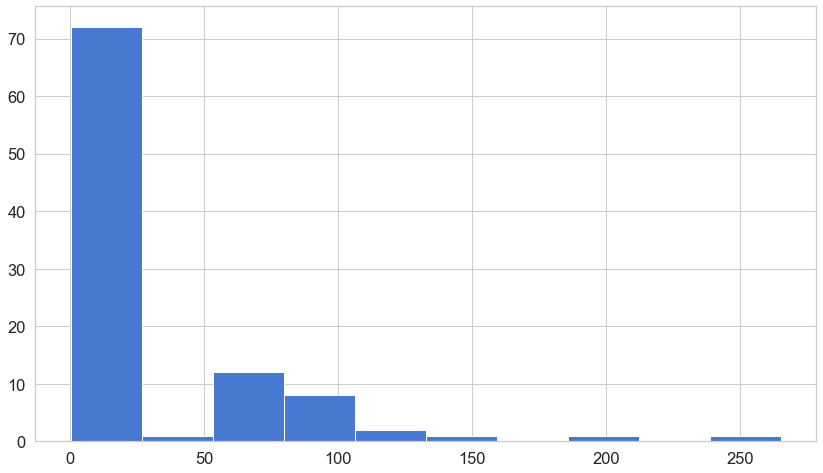

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[(error_df['true_class']==1)]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins =10)

In [33]:
from sklearn.metrics import(confusion_matrix, precision_recall_curve, auc, roc_curve,
                           recall_score, classification_report, f1_score,
                           precision_recall_fscore_support)

ROC curvers are very helpful tool for understading the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at the our ROC curve

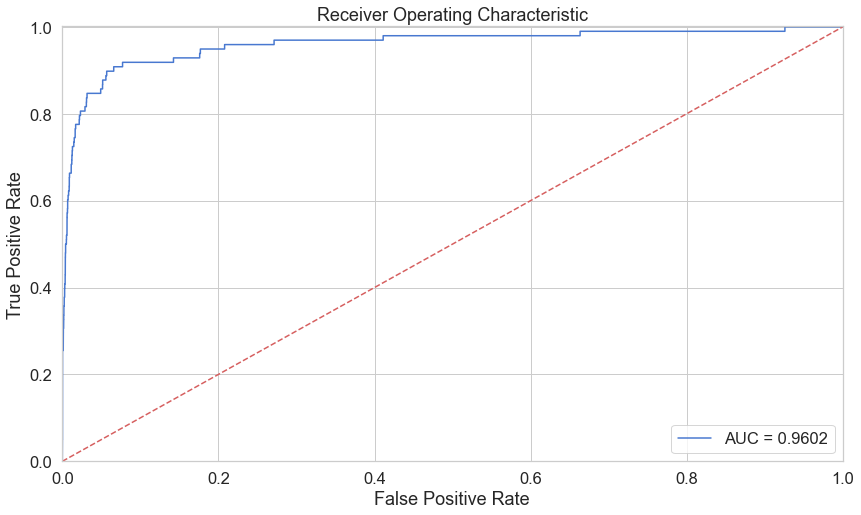

In [34]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0,1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

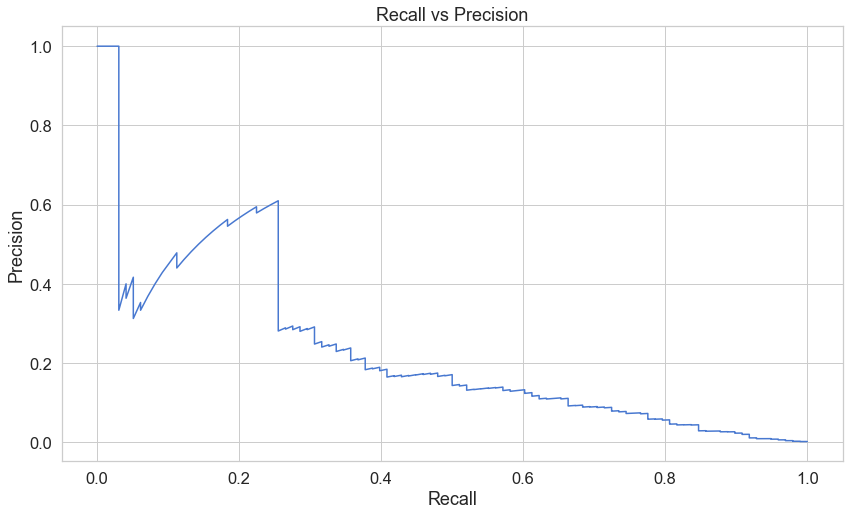

In [35]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall,precision, 'b', label ='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

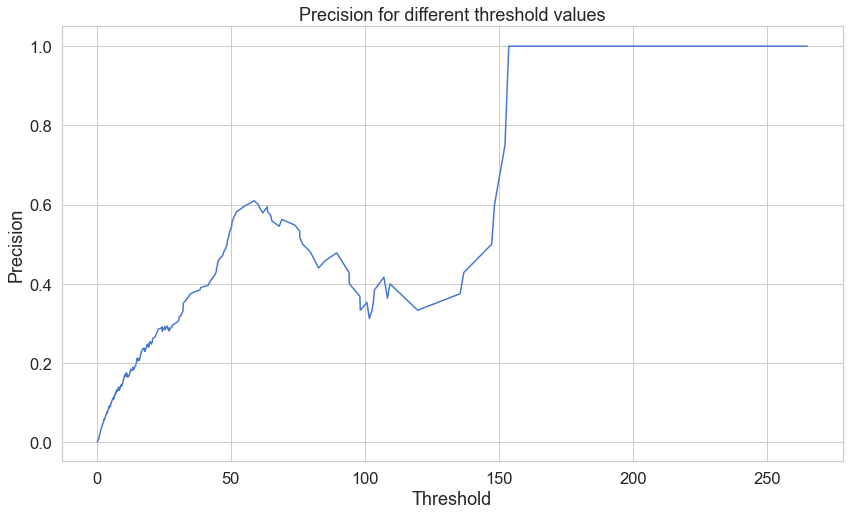

In [36]:
plt.plot(th, precision[1:],'b',label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

As the reconstruction error increases our precision rises as well. Let's have a look at the recall

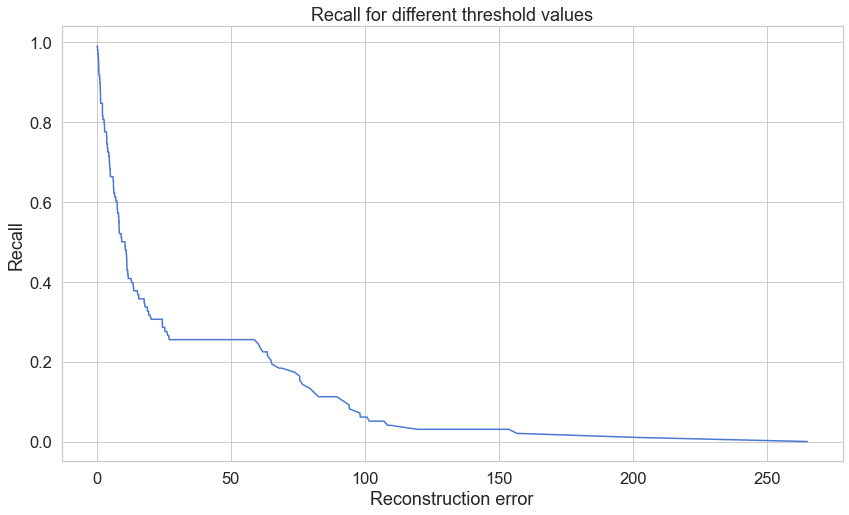

In [37]:
plt.plot(th,recall[1:],'b',label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases

# Prediction

The model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict 
weather or not a new/unseen transaction is normal or fraudulent. We'll calculate the reconstruction error from the transaction
data itself. If the error is larger than a predefined threshold. We'll mark it as a fraud (Since our model should have a low error
on nornal transactions). Let's pick that value



In [38]:
threshold = 2.9

And see how well we're dividing the two types of transactions

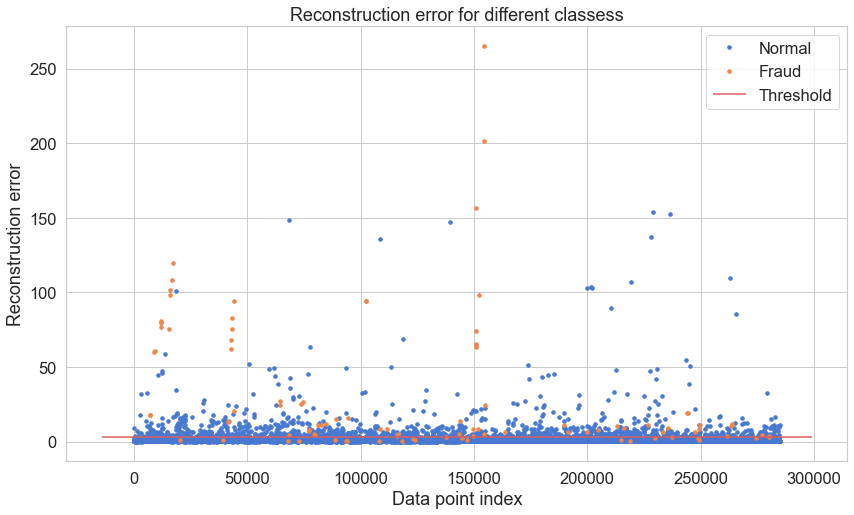

In [39]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms = 3.5, linestyle='',
           label='Fraud' if name ==1 else 'Normal')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors = 'r', zorder=100, label='Threshold')
ax.legend()
plt.title('Reconstruction error for different classess')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show()

The chart might look a bit deceiving. Let's have a look at the confusion matrix

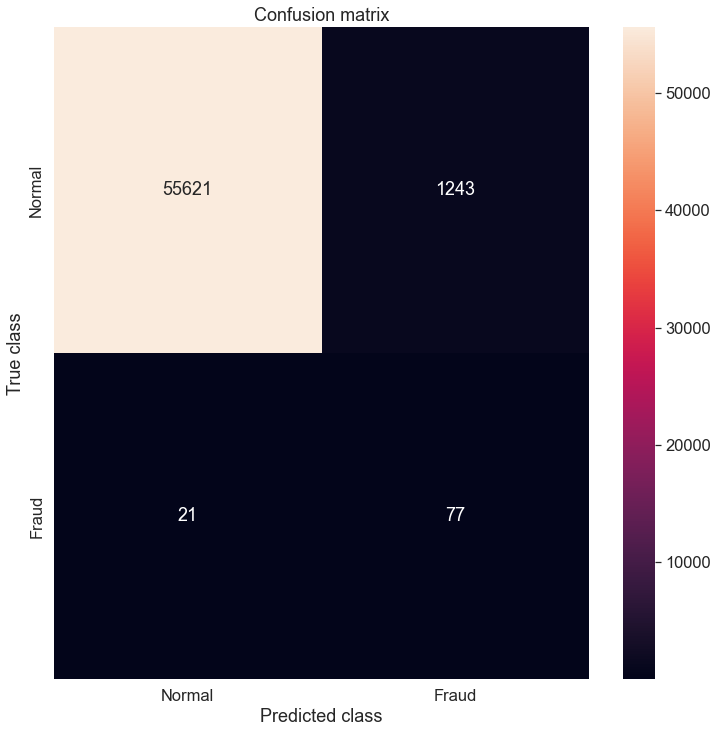

In [40]:
y_predict = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_predict)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Model seems to catch a lot of the fraudulent cases. Of course, there is a catch. The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. We might want to increase or decrease the value of the threshold, depending on the problem.

# Conclusion

Created a Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. 
Model had a lot of one-class examples (normal transactions) to a model and it learned how to discriminate whether or not new examples belong to that same class.  